# Hierarchical Clustering
- Create TF-IDF Matrix
- PCA reduce TF-IDF
- Calculate Euclidean Distance matrix
- Create linkage matrix
- Determine correct number of k by looping through limited range and finding elbow in ROC of distortion for each k 
- Find final k 
- Calculate average distortion and silhouette scores of final clustering
- Unsteam labels
- Sort clusters 
    
Optionally, also find sub-clusters for a search term and the next level down sub-cluster labels

In [1]:
import re
import numpy as np
import pandas as pd
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import sklearn
from scipy.cluster.hierarchy import dendrogram, linkage, ward, fcluster
import networkx as nx
import collections
import math
import operator
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.manifold import TSNE
import scipy.spatial.distance
from nltk.stem.porter import PorterStemmer
import pickle
import gc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gimli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tf-Idf Matrix
- Stemming 
- Tokenize
- Stop word removal

In [2]:
def stemming_tokenizer(str_input):
    
    # initialize Porter Stemmer
    stemmer = PorterStemmer()

    # tokenize input words and stem
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [stemmer.stem(word) for word in words]
    
    return words

In [3]:
def tf_idf(df):
    
    stemmer = PorterStemmer()
    
    # stem stop words before removing
    stop_stem = [stemming_tokenizer(t) for t in stopwords.words('english')]
    stop_stem = [item for sublist in stop_stem for item in sublist]
    
    # tfidf: stop word removal, tokenize and stem
    # set max number of features else memory issues
    tfidf = TfidfVectorizer(stop_words = stop_stem, tokenizer = stemming_tokenizer, max_features = 5000)
    # fit tfidf to corpus
    m = tfidf.fit_transform(df['text'])
    
    # record words in corpus with index
    feature_names = tfidf.get_feature_names() 

    return m, feature_names

### Remove Search from TF-IDF Matrix  
Else will often present the search query as a good label for a cluster. Also do not want to include as a clustering factor. 

In [4]:
def remove_search(tfidf, feature_names, search):
    try: # sometimes search already removed (ex stop word)
        # find index of search in feature_names
        search_index = feature_names.index(search)
        
        # delete from feature_names and tfidf matrix 
        cols = list(range(0,len(feature_names)))
        del cols[cols.index(search_index)]
        tfidf = tfidf[:,cols]
        del feature_names[search_index]
        
    # if error, should be a value error because search not in feature_names
    except ValueError: 
        pass
    except:
        raise 'unknown error'
    
    return tfidf, feature_names

### PCA Dimensionality Reduction
Reduce tfidf matrix

In [5]:
def pca_reduce(tfidf):
    pca = PCA(n_components = 0.8) # keep 80% of variance 
    pca_tfidf = pca.fit_transform(tfidf.toarray()) 
    return pca_tfidf

### Distance Matrix: Euclidean Distance

In [6]:
def dist_calculate(tfidf):
    # Euclidean distance matrix
    dist = euclidean_distances(tfidf)
    # Need flat euclidean distance for linkage matrix 
    flat_dist = scipy.spatial.distance.pdist(tfidf, 'euclidean') 

    return dist, flat_dist

### Linkage Matrix
Create linkage matrix from distance matrix. Ward metric to calculate distance between clusters.

In [7]:
def linkage_calculate(dist):
    linkage_matrix = linkage(dist, method = 'ward') 
    return linkage_matrix

## Create Clusters

__Merge top-level cluster labels with data frame__

In [8]:
def frame_merge(df, f):
    # f is top level clusters. indicate cluster assignments of documents in dataframe
    frameh = pd.DataFrame(df.index, index = [f], columns = ['index_search'])
    frameh = pd.merge(frameh, df, right_index = True, left_on = 'index_search')
    frameh['cluster'] = frameh.index.str[0]
    frameh = frameh.reset_index()
    return frameh

__Find Cluster Centroids and Cluster Labels__

In [9]:
def centroid_label(frameh, tfidf_pca, tfidf, feature_names):
    # most common words in clusters (based on tf-idf not just frequency)
    centroid = dict()
    labels = dict()
    
    # loop through clusters 
    for c in list(frameh.cluster.unique()):
        
        # identify documents in each cluster
        cluster1 = list(frameh[frameh.cluster == c].index.unique())
        # mean vector of tf-idf vectors of documents in cluster
        tfidf1_pca = tfidf_pca[cluster1,:]
        tfidf1_pca = tfidf1_pca.mean(axis = 0)
        centroid[c] = tfidf1_pca

        # label each cluster: 3 largest values words in the centroid
        # use non-reduced tfidf matrix to get actual words
        tfidf1 = tfidf[cluster1,:]
        # take mean vector among all documents
        tfidf1 = tfidf1.mean(axis = 0)
        
        # max values in mean vector 
        lst = []
        for i in np.argsort(np.asarray(tfidf1)[0])[::-1][:3]:  
            lst.append(feature_names[i])
        labels[c] = lst
        
    return labels, centroid

__Find K Top Level Clusters__   
Find clusters, merge into dataframe, and find both centroids and labels

In [10]:
def find_clusters(k, linkage_matrix, tfidf_pca, tfidf, df, feature_names, search):
    # cut dendrogram/linkage matrix to get k top level clusters 
    f = fcluster(linkage_matrix, k, criterion = 'maxclust')
    # merge those clusters into dataframe
    frameh = frame_merge(df, f)
    # find centroids and labels of clusters 
    labels, centroid = centroid_label(frameh, tfidf_pca, tfidf, feature_names)

    return frameh, labels, centroid

__Calculate Silhouette Score__  
Return cluster level and overall average

In [11]:
# calculate individual silhouette for each point 
def silhouette_individ(frameh, dist):
    
    # average distance to points in own cluster
    sil_a = dict()
    # loop through clusters
    for c in list(frameh.cluster.unique()):
        sil_a[c] = dict()
        # all documents in cluster c 
        docs_i = list(frameh[frameh.cluster == c].index.unique())
        # if one document in cluster, then avg distance = 0
        if len(docs_i) == 1:
            sil_a[c][docs_i[0]] = 0
        else:
            # loop through points in each cluster and take mean distance from other points in documents
            for i in docs_i:
                docs_i.remove(i)
                sil_a[c][i] = np.nanmean(dist[i, docs_i].tolist())

    # minimum average distance to points in other clusters 
    # for each point, create list of average distances to points in each other cluster. Take minimum of list
    sil_b = dict()
    # loop through clusters
    for c in list(frameh.cluster.unique()):
        sil_b[c] = dict()
        # all documents in cluster c
        docs_in = list(frameh[frameh.cluster == c].index.unique())
        # loop through points in each cluster -> loop through other clusters -> loop through documents in that cluster 
        for i in docs_in:
            lst = []
            for c2 in list(frameh.cluster.unique()):
                if c2 != c:
                    docs_out = list(frameh[frameh.cluster == c2].index.unique())
                    # loop through documents in other cluster and find average distance
                    lst.append(np.nanmean(dist[i,docs_out].tolist()))
        
            # take minimum of average distance to other clusters
            sil_b[c][i] = np.min(lst)
            
    return sil_a, sil_b

In [12]:
def silhouette_avg_calculate(frameh, dist):
    # silhouette components from each individual point
    sil_a, sil_b = silhouette_individ(frameh, dist)
    
    # take average among points in same cluster to get cluster-level silhouette
    sil_scores = dict()
    for k,v in sil_a.items():
        lst = []
        for i in range(len(v.values())):
            max_ab = max(list(sil_b[k].values())[i], list(sil_a[k].values())[i])
            min_ab = min(list(sil_b[k].values())[i], list(sil_a[k].values())[i])
            # calculate silhouette score 
            lst.append(1 - min_ab/max_ab)
        sil_scores[k] = np.nanmean(lst) 
       
    # take average among all clusters to get overall silhouette
    # return cluster level and overall 
    return sil_scores, np.nanmean(list(sil_scores.values()))

__Calculate Distortion__   
Calculate total and average distortion of a clustering 

In [13]:
def distortion_calculate(tfidf, centroid, frameh):
    sumd = 0
    # sum together distortion for each cluster 
    for i in list(frameh.index.unique()):
        c = int(frameh[frameh.index == i].cluster)
        sumd += (np.linalg.norm(tfidf[i]-centroid[c]))**2
        
    return sumd, sumd / len(frameh)

## Choose K Value: Elbow in ROC of Distortion

In [82]:
def distortion_kvalues(linkage_matrix, tfidf_pca, tfidf, dist, df, feature_names, search):

    distortion = dict()

    # limit to k between 2 and 10. 10 is # search results in Google per page. 
    for k in range(2, 11):
        # find top-level clusters with each k
        frameh, labels, centroid = find_clusters(k, linkage_matrix, tfidf_pca, tfidf, df, feature_names, search)
        # calculate distortion of clusters
        sumd, sumd_avg = distortion_calculate(tfidf_pca, centroid, frameh)
        # record distortion for each k 
        distortion[k] = sumd
        
    return distortion

__ROC of Distortion__

In [15]:
def distortion_roc(distortion):
    # list of ROC of distortion at k values
    roc = []
    for k,v in distortion.items(): 
        if k+1 in distortion:
            roc.append(abs(distortion[k+1] - distortion[k]) / distortion[k])
            
    return roc

__Find K Based on Distortion ROC Elbow__

In [16]:
def find_k(roc):
    # if one value in ROC, then automatically 2 clusters 
    if len(roc) == 1:
        return 2 
    
    # find k using knee method 
    kn = KneeLocator(range(len(roc)), roc, curve='convex', direction='decreasing')
    if kn.knee == None: # sometimes there is no knee, just take the max k in that case
        return len(roc) + 1 # starts at 2. If length = 1, then that's k = 2 to k = 3 --> k = 2 
    k = kn.knee + 2 # index started at 0 and k starts at 2 
                    # if choose index 1 roc that is the second value and going from k = 3 to k = 4 --> k = 3 
    
    return k 

## Clean Clusters for Presentation

__Un-Stem Labels__   
Find the most frequent word corresponding to each stem out of the documents returned for a search   
Replace stems in labels with that word    
Else stems are not always human readable

In [17]:
def labels_unstem_create(df, labels, t):
    
    stemmer = PorterStemmer()
    
    # generate fresh tfidf without stemming
    tfidf = TfidfVectorizer(stop_words = stopwords.words('english'))
    tfidf_norm = tfidf.fit_transform(df['text'])
    words = tfidf.get_feature_names()

    # record stemmed versions of all words in a df
    aux = pd.DataFrame(words, columns =['word'] )
    aux['word_stemmed'] = aux['word'].apply(lambda x : stemmer.stem(x))
    
    # count the frequency of all words 
    vec = sklearn.feature_extraction.text.CountVectorizer().fit(df['text'])
    bag_of_words = vec.transform(df['text'])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = pd.DataFrame(words_freq)
    words_freq.columns = ['word', 'num']
    
    # merge frequency of words with stemming. 
    # sort such that first instance of a stem corresponds to the most frequent variation of that stemmed word
    aux = pd.merge(aux, words_freq, on = 'word', how = 'left')
    aux = aux.sort_values(['word_stemmed', 'num'], ascending = False)
            
    # loop through labels and grab the most frequent un-stemmed word for each stem encountered
    # two versions: 'flat' for regular clusters. 'sub' for sub clusters found in hierarchical function (different structure)
    if t == 'flat':
        labels_unstem = dict()
        # loop through labels
        for i in labels.keys():
            labels_unstem[i] = []
            # loop through words in a each label
            for j in labels[i]:
                if len(aux[aux.word_stemmed == j]) == 0:
                    labels_unstem[i].append(j)
                    continue
                # else take most frequent unstemmed word
                labels_unstem[i].append(aux[aux.word_stemmed == j].word.values[0])
            
    if t == 'sub': 
        labels_unstem = dict()
        for i in labels.keys():
            labels_unstem[i] = []
            ct = 0
            for j in labels[i]:
                labels_unstem[i].append([])
                # additional layer of sublist because each top-cluster has a list of sub-cluster labels
                for k in j:
                    if len(aux[aux.word_stemmed == k]) == 0:
                        labels_unstem[i][ct].append(k)
                        continue
                    labels_unstem[i][ct].append(aux[aux.word_stemmed == k].word.values[0])
                ct += 1
            
    return labels_unstem

__Sort Labels and thus Clusters based on Silhouette Scores * Size of Clusters__

In [18]:
def label_sort(labels, sil_score, frame):
    # multiply silhouette score by number of documents for each cluster: prefer large and well separated clusters 
    for k,v in sil_score.items():
        sil_score[k] = sil_score[k] * len(frame[frame.cluster == k])
    
    # sort revised score
    sil_score = sorted(sil_score.items(), key=operator.itemgetter(1), reverse = True)
    
    # add values in sorted order to labels: ordered dictionary
    labels_sorted = collections.OrderedDict()
    for i in sil_score:
        labels_sorted[i[0]] = labels[i[0]]
        
    return labels_sorted

## Hierarchy: Sub-Clusters    
Create directed graph that allows us to navigate subclusters for a search term: maps how clusters are merged together.   
Additionally, label subclusters and enable ability to extract subclusters for a top-level cluster

__Transform Linkage Matrix such that can understand node linkages__

In [19]:
# raw linkage matrix indicates the linked nodes and then creates an aggregated node with a new index 
# but does not record what that aggregated number is in the same observation as the linkage
# Thus difficult to trace which clusters node x is in all the way up the "tree"
def linkage_df(linkage_matrix, frameh):
    links = pd.DataFrame(linkage_matrix) 
    links.columns = ['source1', 'source2', 'd', 'n']

    # for each linked nodes/documents (source 1 and source 2), indicate the aggregated node it creates 
    links['target'] = 0
    n = len(frameh)-1
    for i, row in links.iterrows():
        n += 1
        links.at[i,'target'] = n
        
    return links

In [20]:
# Helper function: flatten irregular nested lists
    # ex [[a,b], [c], [d, e, f]] -> [a, b, c, d, e, f]
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

__Indicate which documents are at each sub-cluster as traverse up linkages__

In [21]:
def merge_docs(merge, source):
    # merge ids into the given source node
    merge = pd.merge(merge, merge[['target', 'docs']], left_on = source, right_on = 'target',  how = 'left')
    
    # combine docs from merge into a single docs list column
    merge.docs_x = np.where(merge.docs_x.isnull(), '', merge.docs_x)
    merge.docs_y = np.where(merge.docs_y.isnull(), '', merge.docs_y)
    merge['docs'] = merge[['docs_x', 'docs_y']].values.tolist()
    merge = merge.drop(columns = ['docs_x', 'docs_y'])
    merge = merge.rename(columns = {'target_x':'target'})
    
    # flatten docs list column 
    merge.docs = list(merge.docs.apply(lambda row: flatten(row)))
    merge.docs = merge.docs.apply(lambda row: [i for i in row if i != ''])

    return merge

In [22]:
# iteratively merge document ids with the nodes/ids being linked in the linkage matrix
# iterative because need to walk up the "tree" to the more aggregated nodes and indicate all documents in each 
def assign_docs(frameh, links):
    
    # initial merge between frame ids and source1/source2
    merge = pd.merge(links, frameh[['ids']], left_on = 'source1', right_index = True, how = 'left')
    merge = pd.merge(merge, frameh[['ids']], left_on = 'source2', right_index = True, how = 'left')
    
    # combine docs from the merges into a single docs list column 
    merge = merge.rename(columns = {'ids_x':'docs1', 'ids_y':'docs2'})
    merge.docs2 = np.where(merge.docs2.isnull(), '', merge.docs2)
    merge.docs1 = np.where(merge.docs1.isnull(), '', merge.docs1)
    merge['docs']= merge[['docs1', 'docs2']].values.tolist()
    merge = merge.drop(columns = ['docs1', 'docs2'])
    
    # flattern docs list column
    merge.docs = merge.docs.apply(lambda row: [i for i in row if i != ''])
    # calculate length
    merge['len'] = merge.docs.apply(lambda row: len(set(row)))

    # linkage matrix indicates number of documents at each combined node
    # iterate until number of document ids assigned to each combined node equals total 
    while int(merge[merge.target == merge.target.max()].len) != int(merge[merge.target == merge.target.max()].n): 
        merge = merge_docs(merge, 'source1')
        merge = merge_docs(merge, 'source2')
        merge['len'] = merge.docs.apply(lambda row: len(set(row)))
        
        merge = merge.drop(columns = ['target_y'])

    merge.docs = merge.docs.apply(lambda row: set(row))
    
    return merge 

__Assign Graph Attributes: Documents IDs at each Graph Node/Hierarchy Node__

In [23]:
def attributes_docs(G, merge, frameh, links):
    # for each node created by combining documents, add doc list to each target node 
    for i in list(merge.target.unique()):
        G.nodes[i]['docs'] = merge[merge.target == i].docs.values[0]

    # for each original, uncombined node, indicate which document it represents
    origdocs = pd.merge(links, frameh[['ids']], left_on = 'source1', right_index = True, how = 'left')
    origdocs = pd.merge(ogdocs, frameh[['ids']], left_on = 'source2', right_index = True, how = 'left')
    for i in range(len(frameh)):
        if len(origdocs[origdocs.source1 == i].ids_x) != 0:
            G.nodes[i]['docs'] = origdocs[origdocs.source1 == i].ids_x.values[0]
        if len(origdocs[origdocs.source2 == i].ids_y) != 0:
            G.nodes[i]['docs'] = origdocs[origdocs.source2 == i].ids_y.values[0]
            
    return G

__Mark the k Top Level Clusters in the Graph__

In [24]:
def top_cluster(G, frameh):
    nx.set_node_attributes(G, 0, 'cluster')
    # loop through clusters
    for c in list(frameh.cluster.unique()):
        # set of all documents in cluster c based on frameh, which records top level clusters
        # if is exactly equal to the set of documents at a graph node, then top level cluster
        try:
            c_ids = set(frameh[frameh.cluster == c].ids.unique())
            node = [x for x,y in G.nodes(data=True) if y['docs']==c_ids][0] 
        except:
            c_ids = frameh[frameh.cluster == c].ids.unique()
            node = [x for x,y in G.nodes(data=True) if y['docs']==c_ids][0]
        G.nodes[node]['cluster'] = c
        
    return G 

__Create Hierarchy Graph__

In [25]:
def create_graph(links, merge, frameh):
    
    # add nodes for each original document and merged clusters in the linkage matrix 
    G = nx.DiGraph()
    G.add_nodes_from(links.source1)
    G.add_nodes_from(links.source2)
    G.add_nodes_from(links.target)

    # add edges from each document/cluster to its next merged cluster
    subset = links[['source1', 'target']]
    G.add_edges_from([tuple(x) for x in subset.values])
    subset = links[['source2', 'target']]
    G.add_edges_from([tuple(x) for x in subset.values])
    
    # add document IDs
    G = attributes_docs(G, merge, frameh, links)
    
    # mark top clusters
    G = top_cluster(G, frameh)
    
    return G 

__Transform linkage matrix into hierarchy graph__

In [26]:
def create_hierarchy(linkage_matrix, frameh):
    
    # create df from linkage matrix that indicates combined clusters
    links = linkage_df(linkage_matrix, frameh)
    
    # find documents at each cluster
    merge = assign_docs(frameh, links)
    
    # create hierarchy graph
    G = create_graph(links, merge, frameh)
                     
    return G, links

__Labels for all Sub Clusters__

In [27]:
def sub_labels(links, tfidf, frameh, G, feature_names):
    labels_sub = []
    # loop through each sub cluster
    for i in list(range(links.target.max())):
        # list of documents in that sub cluster
        if i < len(frameh):
            cluster1 = list(frameh[frameh.ids == list(G.nodes[i].values())[0]].index.unique())
        else:
            cluster1 = list(frameh[frameh.ids.isin(list(list(G.nodes[i].values())[0]))].index.unique())
        # find mean vector among all tfidf vectors of documents in cluster
        tfidf1 = tfidf[cluster1,:]
        tfidf1 = tfidf1.mean(axis = 0)

        # 3 max values in mean vector = labels
        lst = []
        for i in np.argsort(np.asarray(tfidf1)[0])[::-1][:3]:
            lst.append(feature_names[i])

        labels_sub.append(lst)
    
    return labels_sub        

__Return labels for subclusters one layer down from the top-level clusters__

In [28]:
# get labels for subclusters 1 layer down from top flat clusters
def labels_layerdown(G, frameh, labels_sub):
    # identify the top-level cluster nodes
    topnodes = []
    for c in list(frameh.cluster.unique()):
        topnodes.append([x for x,y in G.nodes(data=True) if y['cluster']==c][0])
        
    # find subcluster labels: 1 level down from topnodes 
    labels1 = dict()
    for i in range(len(topnodes)):
        sub = list(G.predecessors(topnodes[i]))
        labels1[i] = [labels_sub[int(j)] for j in sub]
        
    return labels1

## Main Hierarchy Function: Get Labels of all sub-clusters 1 down from top

In [29]:
def hierarchy_main(linkage_matrix, frameh, tfidf_unreduced, df_subset, feature_names):
    # create graph of hierarchical relationships
    G, links = create_hierarchy(linkage_matrix, frameh)
    # find labels of all subclusters
    labels_sub = sub_labels(links, tfidf_unreduced, frameh, G, feature_names)
    # extract labels from 1 layer down subclusters
    labels1 = labels_layerdown(G, frameh, labels_sub)
    # unstem subclusters
    labels1 = labels_unstem_create(df_subset, labels1, t = 'sub')
    
    return labels1 

# Main Function

In [83]:
# options: if want to explore subclusters of a search term, specifcy hierarchy = True and hsearch = 'desired search'
def main(hierarchy = False, hsearch = False):
    
    # read in processed data
    df = pd.read_pickle('reuters_processed')
    
    # set of topics/search terms
    topics = list(df.categories)
    topics = [item for sublist in topics for item in sublist]
    topics = list(set(topics))
    
    # initialize data structures to store stats for each search query/topic's clustering
    distortion_dict = dict()
    silhouette_dict = dict()
    linkage_dict = dict()
    k_dict = dict()
    labels_dict = dict()
    dist_dict = dict()
    cluster1 = list()
    df_final = pd.DataFrame()
    
    if hierarchy: 
        topics = [hsearch]
    
    # loop through all search queries
    for search in topics:
        # skip two search terms that return a large number of serach tera
        if search == 'earn' or search == 'acq': # too big to deal with
            continue
        
        gc.collect()

        # subset of dataframe for search
        df_subset = df[df.categories.map(set([search]).issubset)] 
        df_subset = df_subset.reset_index()
        
        # if less than 5 documents in search, enforce 1 cluster
        if len(df_subset) < 5:
            cluster1.append(search)
            continue
            
        print(search)
        
        # TF-IDF matrix
        tfidf, feature_names = tf_idf(df_subset)

        # remove search from tf-idf matrix so is not a clustering factor or a label 
        tfidf, feature_names = remove_search(tfidf, feature_names, search)

        # PCA dimensionality reduction of tfidf matrix 
        tfidf_unreduced = tfidf.copy() # store unreduced tfidf to use for labeling
        tfidf = pca_reduce(tfidf)
                    
        # Euclidean distance 
        dist, dist_flat = dist_calculate(tfidf)
                
        # linkage matrix
        linkage_matrix = linkage_calculate(dist_flat)
        
        # find K 
        # if less than 7 documents for search, enforce 2 clusters (only reasonable number)
        if len(df_subset) < 7: 
            k = 2
        else:
            # use non-reduced tfidf to find labels. reduced for everything else. 
            
            # loop through possible k in a restricted range and calculate distortion and silhouette for each
            distortion_lst = distortion_kvalues(linkage_matrix, tfidf, tfidf_unreduced, dist, df_subset,
                                                                       feature_names, search)
            # calculate rate of change in distortion
            roc = distortion_roc(distortion_lst)
            # find k based on elbow in distortion rate of change 
            k = find_k(roc)
            
        # final flat clusters. Annotate dataframe with cluster assignments, determine labels, and calculate centroids 
        frameh, labels, centroid = find_clusters(k, linkage_matrix, tfidf, tfidf_unreduced, 
                                                     df_subset, feature_names, search)
            
        # if this process only returned 1 cluster, skip the rest of the calculations
            # even if give cut function k = 2, it considers that an upper bound, so occassionally still only returns 1
        if frameh.cluster.nunique() == 1:   
            cluster1.append(search)
            continue
                
        # calculate distortion and silhouette for final clusters
        distortion, distortion_avg = distortion_calculate(tfidf, centroid, frameh) # sum of distortion and avg distortion
        silhouette_cluster, silhouette_avg = silhouette_avg_calculate(frameh, dist) # cluster level and overall 

        # un-stem labels
        labels = labels_unstem_create(df_subset, labels, t = 'flat')
        
        # sort clusters (labels) based on cluster silhouette score and size 
        labels = label_sort(labels, silhouette_cluster, frameh)

        # record statistics for this search
        distortion_dict[search] = distortion_avg
        silhouette_dict[search] = silhouette_avg
        linkage_dict[search] = linkage_matrix
        k_dict[search] = k
        labels_dict[search] = labels
        dist_dict[search] = dist

        frameh['search'] = search
        df_final = df_final.append(frameh)
        
        # if hierarchy option selected, 
            # after calculating clusters for this search term, run through hierarchy process to find next level of subclusters
        if hierarchy: 
            labels1 = hierarchy_main(linkage_matrix, frameh, tfidf_unreduced, df_subset, feature_names)
            return labels1

    return distortion_dict, silhouette_dict, k_dict, labels_dict, df_final, dist_dict, linkage_dict, cluster1

In [84]:
distortion_dict, silhouette_dict, k_dict, labels_dict, df_final, dist_dict, linkage_dict, cluster1 = main()

cocoa
retail


C:\Users\Gimli\Anaconda3\lib\site-packages\kneed\knee_locator.py:134: RuntimeWarning: No local maxima found in the difference curve
The line is probably not polynomial, try plotting
the difference curve with plt.plot(knee.x_difference, knee.y_difference)
Also check that you aren't mistakenly setting the curve argument
  RuntimeWarning,


tin
corn
pet-chem
income
jobs
instal-debt
meal-feed
carcass
potato
rapeseed
jet
alum
l-cattle
zinc
nickel
wpi
rape-oil
rubber
heat
trade
soy-oil
crude
naphtha
cotton
tea
money-supply
iron-steel
grain
soybean
propane
oat
ipi
fuel
wheat
sun-oil
groundnut
money-fx
hog
reserves
yen
sunseed
strategic-metal
sugar
dmk
coconut
orange
barley
housing
rice
soy-meal
gold
sorghum
livestock
bop
gas
dlr
interest
lead
silver
nat-gas
platinum
coconut-oil
lei
gnp
ship
coffee
copper
palm-oil
veg-oil
oilseed
lumber
cpi


In [88]:
# save data locally
with open('hierarchial', "wb") as f:
    pickle.dump(df_final, f)
    pickle.dump(labels_dict, f)
    pickle.dump(k_dict, f)
    pickle.dump(distortion_dict, f)
    pickle.dump(silhouette_dict, f)
    pickle.dump(cluster1, f)

In [ ]:
# example call of main function to get sub clusters for a search term 
linkage_matrix, frameh = main(hierarchy = True, hsearch = 'corn')

## Visualization

### Dendrogram

([], <a list of 0 Text yticklabel objects>)

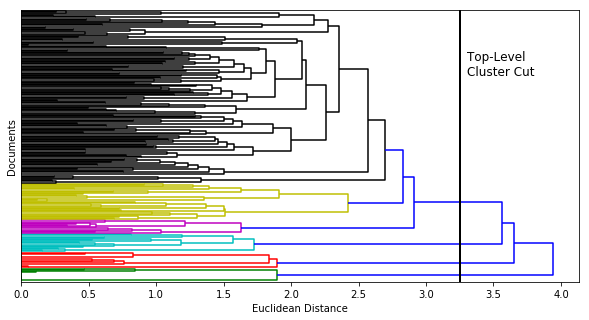

In [90]:
# search cluster we are visualizing 
search = 'corn'

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_dict[search], orientation="right", labels = df_final[df_final.search == search].ids.unique())
# manually draw in cut line for presentation
plt.axvline(3.25, color = 'black', linewidth = 2)
plt.text(3.3, 1800, 'Top-Level \nCluster Cut', fontsize = 12)
ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Documents')
plt.yticks([], [])

### Visualize 2-D clusters using t-SNE

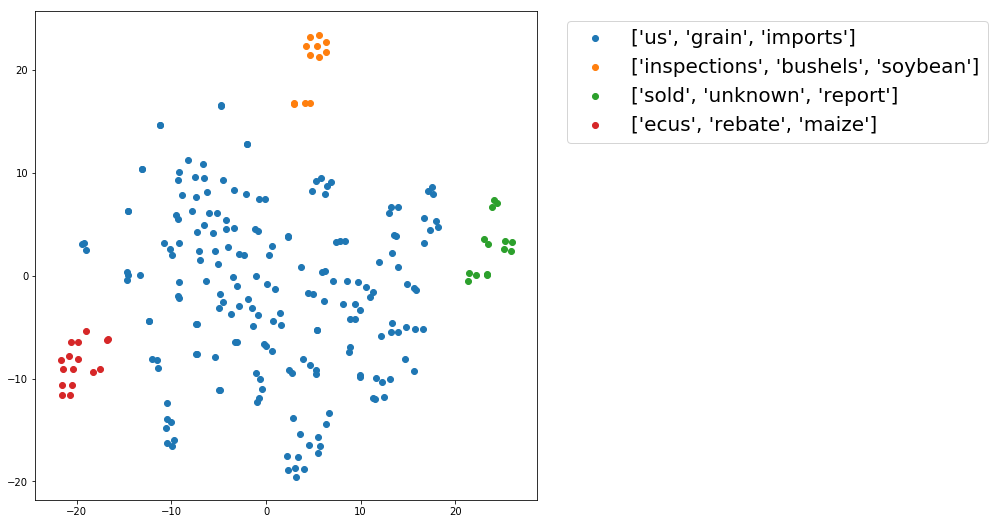

In [89]:
# specify search clusters we are visualizing 
search = 'corn'

# Calculate t-SNE 2D embedding
embed = TSNE(n_components=2).fit_transform(dist_dict[search], 'precomputed')
xs, ys = embed[:, 0], embed[:, 1]

# Create dataframe of embedding and cluster labels  
clusters = df_final[df_final.search == search].cluster.tolist()
df_vis = pd.DataFrame(dict(x = xs, y = ys, cluster = clusters))

# plot
fig, ax = plt.subplots(figsize=(9, 9)) 
# loop through so legend ordered by labels 
for c in labels_dict[search].keys():
    ax.scatter(df_vis[df_vis.cluster == int(c)].x, df_vis[df_vis.cluster == int(c)].y, label = labels_dict[search][c])
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", prop = {'size':20})